# Stratified Covariate Balancing

From [http://openonlinecourses.com/causalanalysis/CovariateBalancing.asp](http://openonlinecourses.com/causalanalysis/CovariateBalancing.asp).

## Load Data

In [1]:
import pandas as pd

df = pd.read_excel('./Expected LOS in 10 Diseases.xlsx')
df = df.rename(columns={
    'Cared for by Dr Smith': 'dr_smith'
})
df.shape

(6657, 11)

In [2]:
df.head()

,Hypertension,Anemia,Diabetes,HIV,Stomach Cancer,Lung Cancer,Myocardial Infarction,Heart Failure,Metastetic Cancer,dr_smith,LOS
0,0,0,0,0,0,0,0,0,0,0,3
1,1,0,0,0,0,0,0,0,0,0,4
2,0,0,0,0,0,0,0,0,0,1,6
3,1,0,0,0,0,0,0,0,0,1,6
4,0,1,0,0,0,0,0,0,0,0,3


## Question 1

### Question 1.1

Simply get the `average` (or proportion of 1's) per variable for those patients treated by Dr. Smith and those that were not. Use a bar chart plot to visualize the difference.

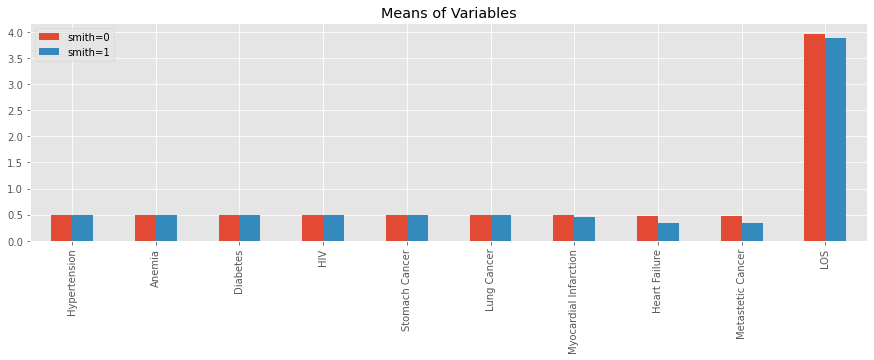

In [3]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

y_col = 'dr_smith'
X_cols = [c for c in df.columns if c != y_col]

_ = pd.DataFrame({
    'smith=0': df[df[y_col] == 0][X_cols].describe().T['mean'],
    'smith=1': df[df[y_col] == 1][X_cols].describe().T['mean']
}).plot(kind='bar', title='Means of Variables', figsize=(15, 4))

You may also try box plots as well.

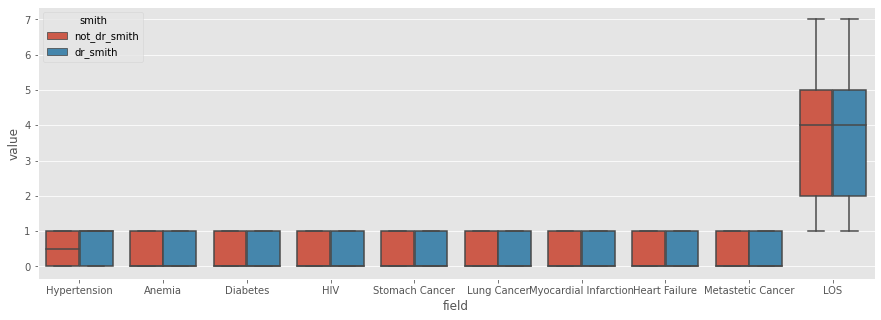

In [4]:
import itertools
import seaborn as sns

def to_long(r):
    smith = 'dr_smith' if r[y_col] == 1 else 'not_dr_smith'
    
    return [(c, smith, r[c]) for c in df.columns if c != y_col]

long_df = pd.DataFrame(itertools.chain(*df.apply(to_long, axis=1)), columns=['field', 'smith', 'value'])

fig, ax = plt.subplots(figsize=(15, 5))
_ = sns.boxplot(x='field', y='value', hue='smith', data=long_df, ax=ax)

This approach will draw 3 decision trees using a Decision Classifier. The 3 decision trees are different by the `max_leaf_nodes` argument (5, 10, None). The drawings will be exported into 3 PDF files.

In [5]:
from sklearn.tree import DecisionTreeClassifier
import graphviz 
from sklearn.tree import export_graphviz

X_cols = [c for c in df.columns if c not in ['LOS', 'dr_smith']]
y_col = 'LOS'
    
def learn(max_leaf_nodes):
    X = df[X_cols]
    y = df[y_col]

    tree = DecisionTreeClassifier(random_state=37, max_leaf_nodes=max_leaf_nodes)
    tree.fit(X, y)
    
    return tree

def draw(tree, file_stem='drsmith'):
    dot_data = export_graphviz(**{
        'decision_tree': tree, 
        'out_file': None,
        'feature_names': X_cols,
        'filled': True,
        'rounded': True,
        'special_characters': True
    })
    graph = graphviz.Source(dot_data) 
    graph.render(file_stem)
    
for max_leaf_nodes in [5, 10, None]:
    tree = learn(max_leaf_nodes)
    draw(tree, file_stem=f'drsmith_{str(max_leaf_nodes)}')

### Question 1.2

There's 6,657 patients, and number of strata based on combination of values for each of the variables is 512.

In [6]:
t_col = 'dr_smith'
o_col = 'LOS'
X_cols = [c for c in df.columns if c not in {t_col, o_col}]

strata_df = df[X_cols].dropna().drop_duplicates().reset_index(drop=True)
strata_df.shape

(512, 9)

We should only be interested in each stratum that has at least 2 samples (one for being treated and one for not being treated by Dr. Smith). For each stratum, we need filter out the ones that do NOT have samples for both patients that were and were not treated by Dr. Smith. Futhermore, length of stay (LOS) is not binary but you can `binarize` this variable into 1 and 0 where a value will be mapped to 0 if it is less than or equal to 4 and 1 otherwise. 

In [7]:
df.LOS.value_counts().sort_index()

1     619
2    1247
3    1118
4    1070
5     959
6     989
7     655
Name: LOS, dtype: int64

In [8]:
def get_query(r):
    query = [f'`{c}` == {r[c]}' for c in strata_df.columns if c not in {'n_samples', 'query', 'drsmith=0', 'drsmith=1'}]
    query = ' and '.join(query)
    return query

def get_count(q, dr_smith):
    if dr_smith is not None:
        query = f'dr_smith == {dr_smith} and {q}'
    else:
        query = q
        
    return df.query(query).shape[0]

strata_df['query'] = strata_df.apply(get_query, axis=1)
strata_df['n_samples'] = strata_df.apply(lambda r: get_count(r['query'], None), axis=1)
strata_df['drsmith=0'] = strata_df.apply(lambda r: get_count(r['query'], 0), axis=1)
strata_df['drsmith=1'] = strata_df.apply(lambda r: get_count(r['query'], 1), axis=1)

In [9]:
strata_df[['n_samples', 'drsmith=0', 'drsmith=1']]

,n_samples,drsmith=0,drsmith=1
0,19,6,13
1,19,6,13
2,19,6,13
3,19,6,13
4,19,6,13
...,...,...,...
507,17,5,12
508,17,5,12
509,17,5,12
510,17,5,12


Each stratum has at least one treated and untreated sample. There is no need to remove a stratum.

In [10]:
strata_df[(strata_df['drsmith=0'] > 0) & (strata_df['drsmith=1'] > 0)].shape

(512, 13)

Let's binarize the LOS column.

In [11]:
df['LOS_binary'] = df['LOS'].apply(lambda los: 1 if los > 4 else 0)

Look in the book on page 386. Let's compute a, b, c, d.

In [12]:
def get_abcd(stratum, dr_smith, los):
    return df.query(stratum) \
            .query(f'dr_smith == {dr_smith} and LOS_binary == {los}') \
            .shape[0]

strata_df['a'] = strata_df.apply(lambda r: get_abcd(r['query'], 1, 1), axis=1)
strata_df['b'] = strata_df.apply(lambda r: get_abcd(r['query'], 1, 0), axis=1)
strata_df['c'] = strata_df.apply(lambda r: get_abcd(r['query'], 0, 1), axis=1)
strata_df['d'] = strata_df.apply(lambda r: get_abcd(r['query'], 0, 0), axis=1)

Let's compute L and w.

In [13]:
import numpy as np

def get_L(r):
    adjust = lambda v: 0.5 if v == 0 else v
    
    a, b, c, d = r['a'], r['b'], r['c'], r['d']
    a, b, c, d = adjust(a), adjust(b), adjust(c), adjust(d)
    
    ad = a * d
    bc = b * c
    
    L = np.log(ad / bc)
    return L

def get_w(r):
    adjust = lambda v: 0.5 if v == 0 else v
    
    a, b, c, d = r['a'], r['b'], r['c'], r['d']
    a, b, c, d = adjust(a), adjust(b), adjust(c), adjust(d)
    a, b, c, d = 1/a, 1/b, 1/c, 1/d
    
    w = 1 / (a + b + c + d)
    return w
    

strata_df['L'] = strata_df.apply(get_L, axis=1)
strata_df['w'] = strata_df.apply(get_w, axis=1)

Let's compute R.

In [14]:
R = np.sum(strata_df.apply(lambda r: r['w'] * r['L'], axis=1)) / np.sum(strata_df['w'])
R

-0.05309454661776104

### Question 1.3

Let's compute the odds ratio (OR).

In [15]:
ad = np.sum(strata_df.apply(lambda r: (r['a'] * r['d']) / (r['a'] + r['b'] + r['c'] + r['d']), axis=1))
bc = np.sum(strata_df.apply(lambda r: (r['b'] * r['c']) / (r['a'] + r['b'] + r['c'] + r['d']), axis=1))

OR = ad / bc
OR

0.9923234169660415

Let's compute the Chi-squared value. The Chi-squared value is 650.9 with 511 degrees of freedom, and the critical value at 95% is 564.7, and so we reject the null hypothesis.

- H0 (null): Being treated by Dr. Smith is not related to the outcome (LOS)
- H1 (alternative): Being treated by Dr. Smith is related to the outcome (LOS)

In [16]:
from scipy.stats import chi2, norm

strata_df['chi_sq'] = strata_df.apply(lambda r: r['w'] * np.power(r['L'] - R, 2.0), axis=1)
chi_sq = np.sum(strata_df['chi_sq'])
dof = strata_df.shape[0] - 1

# chi_sq >= critical, reject
chi_sq, dof, chi2.cdf(chi_sq, dof), chi2.ppf(0.95, dof), chi_sq >= chi2.ppf(0.95, dof)

(650.8849990388384, 511, 0.9999744476737749, 564.6961330869116, True)

### Question 1.4

In [18]:
def get_avg_outcome(stratum, y):
    q = f'dr_smith == {y} and {stratum}'
    n = df.query(q)['LOS'].sum()
    total = df.query(q).shape[0]
    y = n / total
    return y

strata_df['Y=0'] = strata_df.apply(lambda r: get_avg_outcome(r['query'], 0), axis=1)
strata_df['Y=1'] = strata_df.apply(lambda r: get_avg_outcome(r['query'], 1), axis=1)
strata_df['d'] = strata_df['Y=1'] - strata_df['Y=0']

In [19]:
strata_df['d'].mean()

0.012543820112179499